In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as pd
import pandas as pd
import cv2
import pydicom
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
from PIL import Image
from scipy.sparse import load_npz
from tqdm import tqdm_notebook
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.models import Model, model_from_json
from keras.layers import Input, LeakyReLU, core, Dropout, BatchNormalization, Concatenate, Dense, Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Restrict to single GPU
os.environ["CUDA_VISIBLE_DEVICES"]='0'

### Parse Data - Create Annotations

In [3]:
train_path = './siim/dicom-images-train/*/*/*.dcm'
mask_path = './siim/train-rle.csv'
images_to_ram = True # Low or high memory usage
img_height = 512
img_width = 512
n_channels = 1
batch_size = 8
epochs = 100

In [4]:
def get_train_df(train_path=train_path, mask_path=mask_path, images_to_ram=False, mask_img=False):
    rles_df = pd.read_csv(mask_path)
    rles_df.columns = ['ImageId', 'EncodedPixels']
        
    metadata_list = []
    train_fps = glob(train_path)

    if images_to_ram is True:
        img_dict = {}
    for i, fp in tqdm_notebook(enumerate(train_fps)):
        metadata = {}
        dcm = pydicom.dcmread(fp)
        metadata['ImageId'] = dcm.SOPInstanceUID
        metadata['Filepath'] = fp
        
        encoded_pixels_list = rles_df[rles_df['ImageId']==dcm.SOPInstanceUID]['EncodedPixels'].values
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        metadata['Pneumothorax'] = pneumothorax
        
        if images_to_ram is True:
            metadata['PixelArray'] = dcm.pixel_array
            if mask_img is True:
                if pneumothorax is True:
                    metadata['EncodedPixels'] = load_npz('siim/mask/'+dcm.SOPInstanceUID+'.npz').todense().astype('uint8')
                else:
                    metadata['EncodedPixels'] = np.zeros((1024, 1024))
                
        metadata_list.append(metadata)

    return pd.DataFrame(metadata_list)

In [5]:
df = get_train_df(train_path, mask_path, images_to_ram=True)

In [6]:
df.head()

,ImageId,Filepath,Pneumothorax,PixelArray,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.31935.15178751...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[1, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1.2.276.0.7230010.3.1.4.8323329.4297.151787518...,./siim/dicom-images-train/1.2.276.0.7230010.3....,True,"[[1, 0, 1, 0, 0, 3, 0, 0, 2, 1, 1, 0, 0, 0, 0,...","[[[[[0 0 0 ... 0 0 0]]]], [[[[0 0 0 ... 0 0 0]..."
2,1.2.276.0.7230010.3.1.4.8323329.12953.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1.2.276.0.7230010.3.1.4.8323329.12901.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[86, 87, 88, 88, 88, 88, 87, 86, 86, 86, 86, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1.2.276.0.7230010.3.1.4.8323329.12036.15178752...,./siim/dicom-images-train/1.2.276.0.7230010.3....,False,"[[153, 139, 123, 107, 94, 84, 75, 65, 57, 52, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Split and Balance the Data

In [7]:
# Imbalance between Pos and Neg classifications:
#len(rles_df[rles_df.Pneumothorax == 1]), len(rles_df[rles_df.Pneumothorax == 0])
len(df[df.Pneumothorax == True]), len(df[df.Pneumothorax == False])

(2379, 8296)

In [8]:
#train_df, val_df = train_test_split(rles_df, stratify=rles_df.Pneumothorax, test_size=0.2, random_state=88)
train_df, val_df = train_test_split(df, stratify=df.Pneumothorax, test_size=0.2, random_state=88)

img_height = 1024
img_width = 1024
batch_size = 16

In [19]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_frame,
                 batch_size=4,
                 augmentations=None,
                 img_height=512,
                 img_width=512,
                 n_channels=1,
                 shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.augment = augmentations
        self.img_height = img_height
        self.img_width = img_width
        self.n_channels = n_channels
        self.shuffle = shuffle
        #self.indexes = np.arange(len(self.data_frame))
        self.on_epoch_end()
        
    def __len__(self):
        'Batches per epoch'
        return int(np.ceil(len(self.data_frame) / self.batch_size))
    
    def on_epoch_end(self):
        'Update indexes when epoch ends'
        self.indexes = np.arange(len(self.data_frame))
        if self.shuffle == True:
            #self.indexes = np.arange(len(self.data_frame))
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Get one batch'
        batch_indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.data_frame))]
        
        #fps = self.data_frame.iloc[batch_indexes].FilePath
        
        #X = self.data_generation(fps)
        #Y = self.data_frame.iloc[batch_indexes][['Pneumothorax', 'NotPneumothorax']]
        X, Y = self.data_generation(batch_indexes)
        
        if self.augment is None:
            return np.array(X)/255, np.array(Y)
        else:
            X_aug, Y_aug = [], []
            for image, mask in zip(X, Y):
                augmented = self.augment(image=image, mask=mask)
                X_aug.append(augmented['image'])
                Y_aug.append(augmented['mask'])
            return np.array(X_aug)/255, np.array(Y_aug)
        
    #def data_generation(self, fps):
    def data_generation(self, batch_indexes):
        if 'PixelArray' in self.data_frame.columns:
            X = [cv2.resize(img, (self.img_height, self.img_width)) for img in self.data_frame.iloc[batch_indexes]['PixelArray']]
            X = np.expand_dims(X, axis=3)
            #X = cv2.resize(self.data_frame.iloc[batch_indexes]['PixelArray'], (self.img_height, self.img_width)), axis=2)
        else:   
            fps = self.data_frame.iloc[batch_indexes].FilePath
            X = np.empty((len(fps), self.img_height, self.img_width, self.n_channels))
            for i, fp in enumerate(fps):
                dcm = pydicom.dcmread(fp)
                X[i] = np.expand_dims(cv2.resize(dcm.pixel_array, (self.img_height, self.img_width)), axis=2)

        Y = pd.concat([self.data_frame.iloc[batch_indexes]['Pneumothorax']+0,
                      np.invert(self.data_frame.iloc[batch_indexes]['Pneumothorax'])+0],
                      axis=1) 
        
        return np.uint8(X), np.uint8(Y)

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=img_height, width=img_width,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

### Check Augmentations

In [20]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()

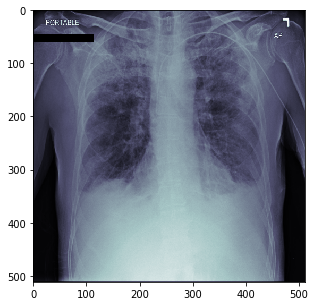

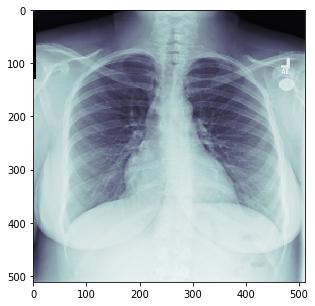

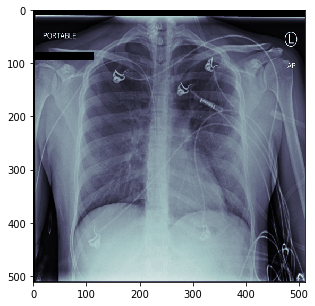

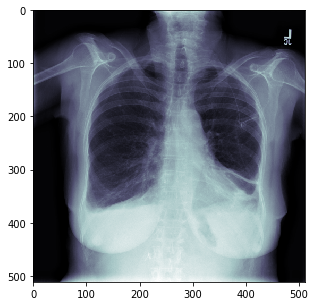

[[0 1]
 [0 1]
 [0 1]
 [0 1]] (4, 512, 512, 1)


In [23]:
a = DataGenerator(data_frame=train_df, batch_size=4, shuffle=False)
images, masks = a.__getitem__(0)
for image in images.squeeze():
    plot_pixel_array(image, (5, 5))
print(masks, images.shape)

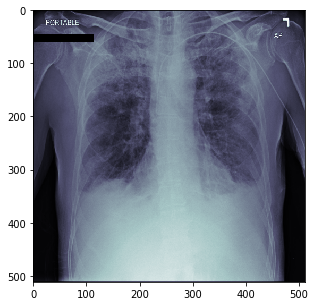

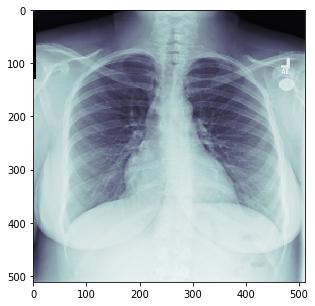

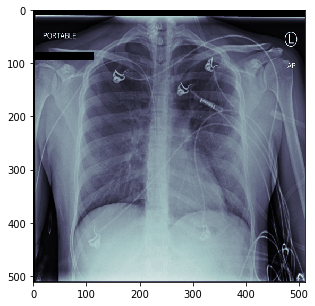

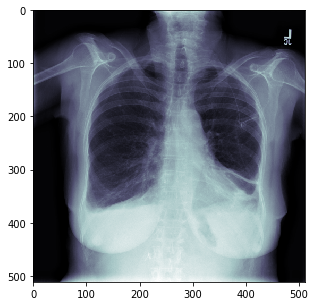

In [24]:
# After augmentations
b = DataGenerator(data_frame=train_df, batch_size=4, augmentations=AUGMENTATIONS_TRAIN, shuffle=False)
images, masks = a.__getitem__(0)
for image in images.squeeze():
    plot_pixel_array(image, (5, 5))

### Balance Data

### Data Loader with Augmentations

### Finetune Pretrained Networks

In [25]:
def get_resnet50(img_height=img_height, img_width=img_width, n_channels=n_channels):
    inputs = Input(shape=(img_height, img_width, n_channels))
    conc = Concatenate()([inputs, inputs, inputs])
    
    base = ResNet50(include_top=False, weights='imagenet', input_tensor = conc, classes=2)
    
    for layer in base.layers:
        layer.trainable = True
    
    outputs = GlobalAveragePooling2D()(base.output)
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def get_resnext50(img_height=img_height, img_width=img_width, n_channels=n_channels):
    inputs = Input(shape=(img_height, img_width, n_channels))
    conc = Concatenate()([inputs, inputs, inputs])
    
    base = ResNeXt50(include_top=False, weights='imagenet', input_tensor = conc, classes=2)
    
    for layer in base.layers:
        layer.trainable = True
    
    outputs = GlobalAveragePooling2D()(base.output)
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [26]:
K.clear_session()
model = get_resnet50()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           concatenate_1[0][0]              
__________________________________________________________________________________________________
conv1 (Con

In [27]:
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint('./save/resnet50_best.h5', verbose=1, save_best_only=True)

In [28]:
training_generator = DataGenerator(data_frame=train_df, img_height=img_height, img_width=img_width, batch_size=batch_size)
validation_generator = DataGenerator(data_frame=val_df, img_height=img_height, img_width=img_width, batch_size=batch_size)
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[checkpointer])

Epoch 1/100


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[16,32,32,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_41-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss/mul/_3775]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[16,32,32,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_41-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
model.save_weights('./save/resnet50_final.h5', overwrite=True)

### Sanity Check on Validation

In [ ]:
validation_generator = DataGenerator(data_frame=val_df, img_height=img_height, img_width=img_width, batch_size=batch_size, shuffle=False)
preds_val = model.predict_generator(validation_generator)

In [ ]:
z = np.argmax(preds_val, axis=-1)
z[0:10]
p = np.argmax(val_df.)
#acc = K.mean(K.equal(K.argmax(val_df.)))

In [ ]:
preds_val[0]
np.argmax(np.array(val_df[['Pneumothorax', 'NotPneumothorax']]), axis=-1)

In [ ]:
acc = np.mean(np.equal(np.argmax(preds_val, axis=-1), np.argmax(np.array(val_df[['Pneumothorax', 'NotPneumothorax']]), axis=-1)))
print(acc)

In [ ]:
#history.history['val_loss'][1:]